# Load Required Packages

In [1]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(coloc))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(R.utils))
suppressPackageStartupMessages(library(remotes))
suppressPackageStartupMessages(library(tryCatchLog))
suppressPackageStartupMessages(library(qqman))
suppressPackageStartupMessages(library(Rfast))
suppressPackageStartupMessages(library(susieR))
suppressPackageStartupMessages(library(ggrastr))
suppressPackageStartupMessages(library(gridExtra))

In [2]:
setwd('/nfs/lab/relgamal/UKB-PPP/')
files <- list.files('/nfs/lab/relgamal/UKB-PPP/', pattern = '.tsv.gz')
all_proteins <- as.data.frame(str_split_fixed(files, '_', n=5))$V1
all_proteins2 <- paste0(all_proteins, '_')

In [3]:
multi_panel_proteins <- all_proteins2[duplicated(all_proteins2)]
unique(multi_panel_proteins)

[1] "CXCL8_" "IDO1_"  "IL6_"   "LMOD1_" "SCRIB_" "TNF_"

In [171]:
for (x in multi_panel_proteins){

    protein_name <- gsub('_', '',x)
    protein_files <- files[grep(paste0('\\b',x), files)]

    for (y in protein_files){
        name_w_panel <- gsub('_all_chr.tsv.gz', '', y)
        protein_sumstat <- fread(y, header = TRUE, fill = TRUE)
        protein_sumstat$P <- 10^(-protein_sumstat$LOG10P)
        protein_sumstat <- protein_sumstat[order(protein_sumstat$P),]
        protein_sumstat$P <- as.numeric(protein_sumstat$P)

        top_pval <- protein_sumstat[1,]

        peaks <- NULL
        while (min(protein_sumstat$P)<5e-8) {
            top_pval <- protein_sumstat[1,]    
            sumstat_subset <- protein_sumstat[which(protein_sumstat$GENPOS > (top_pval$GENPOS - 1000000) & protein_sumstat$GENPOS < (top_pval$GENPOS + 1000000) & protein_sumstat$CHROM == top_pval$CHROM)]
            fwrite(sumstat_subset, paste0('/nfs/lab/relgamal/UKB-PPP/coloc/Peaks2/', name_w_panel, '_', unique(sumstat_subset$CHROM), '_', unique(min(sumstat_subset$GENPOS)), '_', unique(max(sumstat_subset$GENPOS)), '.tsv'), row.names=FALSE, col.names=TRUE, quote = FALSE, sep='\t')
            peaks <- rbind(peaks, sumstat_subset)
            protein_sumstat <- setdiff(protein_sumstat, sumstat_subset)
        }
    }
}

In [172]:
setwd('/nfs/lab/relgamal/UKB-PPP/coloc/Peaks2/')
files3 <- list.files('/nfs/lab/relgamal/UKB-PPP/coloc/Peaks2/', pattern = '.tsv')

for (x in files3) {
    peaks_file_name <- sub('.tsv','', x)
    peaks <- fread(x, header = TRUE)
    peaks2 <- peaks[which(peaks$ALLELE0 == 'A' | peaks$ALLELE0 == 'C' | peaks$ALLELE0 == 'T' |peaks$ALLELE0 == 'G')]
    peaks3 <- peaks2[which(peaks2$ALLELE1 == 'A' | peaks2$ALLELE1 == 'C' | peaks2$ALLELE1 == 'T' |peaks2$ALLELE1 == 'G')]
    peaks3$SNP_hg38 <- paste0('chr', peaks3$CHROM, ':', peaks3$GENPOS, '_', peaks3$ALLELE0, '_', peaks3$ALLELE1)
    
    writeLines(peaks3$SNP_hg38, paste0('/nfs/lab/relgamal/UKB-PPP/coloc/Peaks2/', peaks_file_name, '.txt'))    
    }

# Run coloc

In [2]:
#T1D no UKB
t1d_no_ukb <- fread('/nfs/lab/relgamal/T1D_T2D_GWAS/T1D_meta_no_UKB.all_chr.hg38.sumstats.txt.gz')
t1d_no_ukb <- t1d_no_ukb[t1d_no_ukb$CHR != 'X', ]
t1d_no_ukb$CHR <- as.integer(t1d_no_ukb$CHR)
t1d_no_ukb$PVALUE <- as.numeric(t1d_no_ukb$PVALUE)

In [3]:
peaks <- list.files('/nfs/lab/relgamal/UKB-PPP/coloc/Peaks/', pattern ='.tsv')
more_sig_files <- fread('/nfs/lab/relgamal/Panc_Enzyme_Project/UKB-PPP_pQTL_coloc_peaks_1p7e-11.txt', header=FALSE)
peaks <- more_sig_files$V1

In [21]:
peaks[grep('SRC_5', peaks)]
which(peaks == 'SRC_5_131485468_133485168.tsv')

[1] "SRC_5_131485468_133485168.tsv"

[1] 14496

In [22]:
result_table <- data.frame()
result_table2 <- data.frame()

for (i in peaks[14496]){
setwd('/nfs/lab/relgamal/UKB-PPP/coloc/Peaks/')
peak_name <- sub('.tsv', '', i)
snp_list <- fread(paste0(peak_name, '.txt'),header = FALSE)
snp_list2 <- snp_list$V1
snp_list3 <- gsub('chr', '', snp_list2)
snp_list3 <- gsub('_', ':', snp_list3)

peak_protein_name <- str_split_fixed(peak_name, '_', n=4)[1]
peak_protein_name <- paste0(peak_protein_name, '_')

all_proteins <- list.files('/nfs/lab/relgamal/UKB-PPP/', pattern = 'all_chr.tsv.gz')

protein0 <- grep(paste0('\\b',peak_protein_name), all_proteins, value = TRUE)

if (length(protein0) == 1){
    protein <- fread(paste0('/nfs/lab/relgamal/UKB-PPP/', protein0))
    protein_subset <- fread(paste0(peak_name, '.tsv'))

    gwas_sumstats <- t1d_no_ukb[which(t1d_no_ukb$SNPID %in% snp_list3),]

    if (nrow(gwas_sumstats)>0){

        protein_subset$alleles <- apply(protein_subset[,c('ALLELE1', 'ALLELE0')], 1, function(x) paste(x[order(x)], collapse=''))
        gwas_sumstats$alleles <- apply(gwas_sumstats[,c('ALT', 'REF')], 1, function(x) paste(x[order(x)], collapse=''))

        m <- merge(gwas_sumstats,protein_subset, by.x=c('CHR', 'POS', 'alleles'), by.y=c('CHROM', 'GENPOS', 'alleles'))
        m <- m[!duplicated(m$SNPID)]

        m$gwas_maf <- sapply(m$AF, function(x) min(c(x, 1-x)))
        m$gwas_flip <- m$AF < 0.5
        m$gwas_beta_alt <- m$BETA.x * (c(-1,1)[m$gwas_flip +1]) 
        m$protein_maf <- sapply(m$A1FREQ, function(x) min(c(x, 1-x)))
        m$protein_flip <- m$A1FREQ < 0.5
        m$protein_beta_alt <- m$BETA.y*(c(-1,1)[m$protein_flip +1]) 

        m <-m[!(m$gwas_maf == 0)]
        m <-m[!(m$AF == 0)]
        m <-m[!(m$protein_maf == 1)]
        m <-m[!(m$A1FREQ == 1)]

        gwas_dataset = list(beta = m$gwas_beta_alt,
                varbeta = m$SE.x^2,
                  type = 'quant',
                  snp = m$SNPID,
                  MAF = m$gwas_maf, 
                  N = m$N.x)

        protein_dataset = list(varbeta = m$SE.y^2, 
                          N = m$N.y,  
                          MAF = m$protein_maf, 
                          type = 'quant', 
                          beta = m$protein_beta_alt,
                          snp = m$SNPID)

        coloc_res <- coloc::coloc.abf(dataset1 = protein_dataset, dataset2 = gwas_dataset,p1 = 1e-4, p2 = 1e-4, p12 = 1e-5)
        result0 <- as.list(coloc_res$summary)
        ppH4 <-result0$PP.H4.abf

        result_table <- cbind(peak_name, ppH4)
        result_table2 <- rbind(result_table, result_table2)
    }
}
}
result_table2$ppH4 <- as.numeric(result_table2$ppH4)
result_table2 <- result_table2[order(-result_table2$ppH4),]

# pdf(paste0('/nfs/lab/relgamal/Locus_Plots2/',tolower(merge3$Protein[a]),'_',str_split_fixed(tolower(merge3$T1D_CS_Signal_hg38[a]), '_', n=2)[1],'.pdf'), width=10, height=5, onefile = TRUE)
# options(repr.plot.width=10, repr.plot.height=5)
# p1 <- ggplot(m, aes(x=POS, y=-log10(m$P_VALUE))) + geom_point(col='#74a9cf', alpha = 0.3) + theme_classic(base_size=20) + xlab('Position') + ylab('-log10(p-value)') +theme(axis.line=element_line(size=0.5)) + ggtitle(paste0(merge3$Protein[a],' (', round(coloc_res$summary[6]*100,1), '% PPH4)'))
# p2 <- ggplot(m, aes(x=POS, y=-log10(m$PVALUE))) + geom_point(col='#023857', alpha = 0.3) + theme_classic(base_size=20) + xlab('Position') + ylab('-log10(p-value)') +theme(axis.line=element_line(size=0.5)) + ggtitle(paste0('T1D (',str_split_fixed(merge3$T1D_CS_Signal_hg38[a], '_', n=2)[1],')'))
# print(p1)
# print(p2)
# plot_genes_all(protein_coding[protein_coding$chrom==paste0('chr',m$CHR[1]),], from = min(m$POS), to=max(m$POS), exp=5)
# dev.off()                                                                  

Warning message in sdY.est(d$varbeta, d$MAF, d$N):
“estimating sdY from maf and varbeta, please directly supply sdY if known”
Warning message in sdY.est(d$varbeta, d$MAF, d$N):
“estimating sdY from maf and varbeta, please directly supply sdY if known”


PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 5.65e-09  1.04e-02  3.47e-08  6.28e-02  9.27e-01 
[1] "PP abf for shared variant: 92.7%"


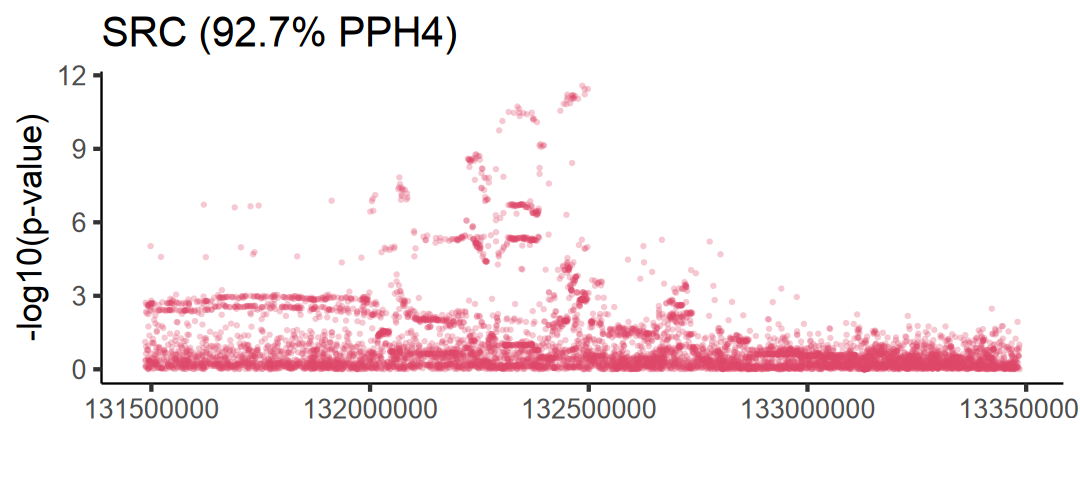

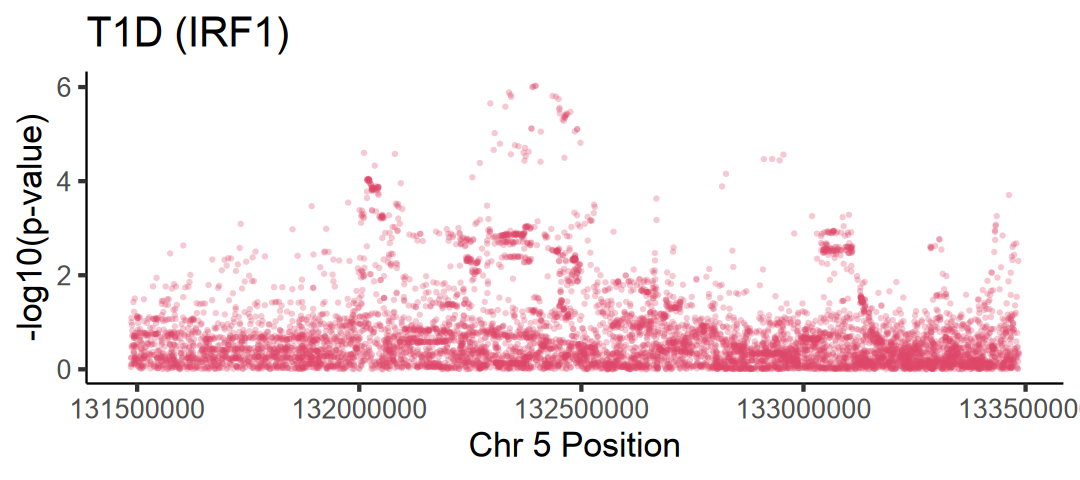

In [29]:
source('/nfs/lab/relgamal/Scripts/plot_genes_all.r')
# pdf(paste0('/nfs/lab/relgamal/Locus_Plots2/',tolower(merge3$Protein[a]),'_',str_split_fixed(tolower(merge3$T1D_CS_Signal_hg38[a]), '_', n=2)[1],'.pdf'), width=10, height=5, onefile = TRUE)
# pdf('/nfs/lab/relgamal/test3.pdf', height=4, width=9)
options(repr.plot.width=9, repr.plot.height=4)
p1 <- ggplot(m, aes(x=POS, y=-log10(m$P_VALUE))) + geom_point(col='#de4968', alpha = 0.3,stroke=NA) + theme_classic(base_size=20) + xlab('') + ylab('-log10(p-value)') +theme(axis.line=element_line(size=0.5)) + ggtitle(paste0('SRC (', round(coloc_res$summary[6]*100,1), '% PPH4)')) #+   theme(axis.title.x=element_blank(),
#         axis.text.x=element_blank(),
#         axis.ticks.x=element_blank())
p2 <- ggplot(m, aes(x=POS, y=-log10(m$PVALUE))) + geom_point(col='#de4968', alpha = 0.3,stroke=NA) + theme_classic(base_size=20) + xlab('Chr 5 Position') + ylab('-log10(p-value)') +theme(axis.line=element_line(size=0.5)) + ggtitle(paste0('T1D (IRF1)'))
print(p1)
print(p2)
# plot_genes_all(protein_coding[protein_coding$chrom==paste0('chr',m$CHR[1]),], from = min(m$POS), to=max(m$POS), exp=5)
# dev.off() 

In [30]:
options(repr.plot.width=8, repr.plot.height=8)
pdf('/nfs/lab/relgamal/test3.pdf', height=8, width=8)
ggarrange(p1, p2, ncol = 1, nrow = 2)
dev.off()

png 
  2

# Colorful Plot

In [24]:
m_cpa1 <- m
min(m_cpa1$POS)
max(m_cpa1$POS)

[1] 74201212

[1] 76200758

In [28]:
m_pnliprp1 <- m
min(m_pnliprp1$POS)
max(m_pnliprp1$POS)

m_pnliprp1[which(m_pnliprp1$P_VALUE == 0),]$P_VALUE <- 1.668805e-308

[1] 74200704

[1] 76200286

In [32]:
m_prss2 <- m
min(m_prss2$POS)
max(m_prss2$POS)

[1] 74201212

[1] 76200758

In [38]:
pdf('/nfs/lab/relgamal/test3.pdf', width=10, height=7.5)
options(repr.plot.width=10, repr.plot.height=7.5)
p1 <- ggplot(m_cpa1, aes(x=POS, y=-log10(m_cpa1$P_VALUE))) + rasterise(geom_point(col='#FD6F30', alpha = 0.3, stroke=NA),dpi = 1000) + theme_classic(base_size=20) +xlab('') +ylab('') +theme(axis.line=element_line(size=0.5))  +xlim(74201212,76200286)
p2 <- ggplot(m_pnliprp1, aes(x=POS, y=-log10(m_pnliprp1$P_VALUE))) + rasterise(geom_point(col='#FD6F30', alpha = 0.3,stroke=NA), dpi=1000) + theme_classic(base_size=20) +xlab('') +ylab('')+theme(axis.line=element_line(size=0.5)) +xlim(74201212,76200286)
p3 <- ggplot(m_prss2, aes(x=POS, y=-log10(m_prss2$P_VALUE))) + rasterise(geom_point(col='#FD6F30', alpha = 0.3,stroke=NA), dpi=1000) + theme_classic(base_size=20) +xlab('')+ylab('')+theme(axis.line=element_line(size=0.5)) +xlim(74201212,76200286)
p4 <- ggplot(m, aes(x=POS, y=-log10(m$PVALUE))) + rasterise(geom_point(col='#FD6F30', alpha = 0.3,stroke=NA),dpi=1000) + theme_classic(base_size=20) + xlab('Position') + ylab(expression(paste('-log'[10],'(p-value)'))) +theme(axis.line=element_line(size=0.5))+geom_vline(xintercept = 75197100)+geom_vline(xintercept = 75204900)+xlim(74201212,76200286)
grid.arrange(p1, p2,p3,p4, nrow = 4)
# plot_genes_all(protein_coding[protein_coding$chrom==paste0('chr',m$CHR[1]),], from = min(m$POS), to=max(m$POS), exp=5)
dev.off()  

Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_point()`).”


png 
  2